In [38]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools

import matplotlib.pyplot as plt
#import tensorflow

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
'''
from tensorflow import keras
from keras.utils.np_utils import to_categorical
'''
import warnings
import os

warnings.simplefilter("ignore")

### Read processed data from file

<p>Reading the labels and the features</p>

In [3]:
# Upload data

labels = pd.read_csv("labels.csv", names=["match", "label"])
labels = labels.replace({'Defeat': 0}, regex=True)
labels = labels.replace({'Draw': 1}, regex=True)
labels = labels.replace({'Win': 2}, regex=True)
labels = labels.drop('match', axis=1)


features = pd.read_csv("features.csv")
features.rename( columns={'Unnamed: 0':'match'}, inplace=True )
features = features.drop('match', axis=1)
features.head(5)

,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_home,games_against_away,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,home_player_4_overall_rating,...,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating,odds_home,odds_draw,odds_away
0,-9.0,7.0,2.0,6.0,0.0,1.0,71.0,59.0,61.0,67.0,...,66.0,69.0,68.0,68.0,72.0,66.0,63.0,0.379532,0.287801,0.332667
1,-5.0,-12.0,2.0,1.0,0.0,1.0,64.0,61.0,69.0,64.0,...,63.0,66.0,67.0,62.0,65.0,62.0,66.0,0.503166,0.266833,0.230001
2,5.0,3.0,5.0,4.0,0.0,2.0,69.0,70.0,72.0,66.0,...,64.0,62.0,61.0,66.0,65.0,72.0,70.0,0.530293,0.264442,0.205265
3,0.0,-5.0,4.0,2.0,0.0,0.0,69.0,68.0,69.0,64.0,...,60.0,63.0,64.0,59.0,61.0,64.0,56.0,0.580711,0.246617,0.172672
4,11.0,0.0,8.0,0.0,0.0,0.0,65.0,71.0,72.0,73.0,...,60.0,61.0,67.0,66.0,61.0,66.0,63.0,0.695433,0.190179,0.114387


### Classification

Use of DecisionTreeClassifier with and without k-fold cross-validation,  GridSearchCV for parameter tunning 
and use of Random Forest Classifiers


In [18]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#all_inputs[:5]

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(features, labels, test_size=0.25, random_state=1)



### Decision Tree

In [7]:
# decion tree classifier (not very good classifier)
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.3972602739726027

''

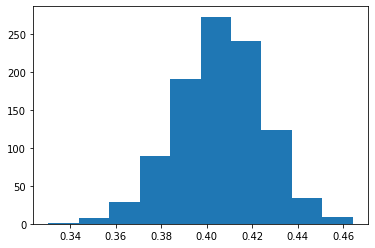

In [9]:
## from this we can see that the problem is dependent on the subset we are
# using => overfitting
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(features, labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)
;

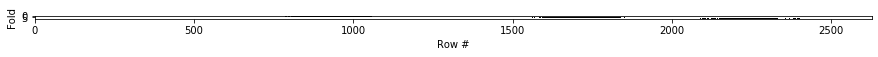

In [10]:
## cross validation
def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), features, labels)

''

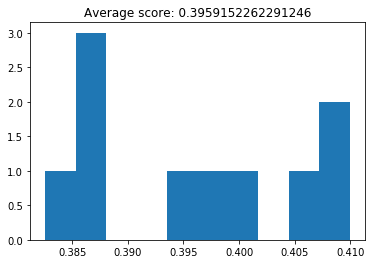

In [11]:
# Now we have a more consistent rating: however is not that good
from sklearn.model_selection import cross_val_score
decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, features, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

''

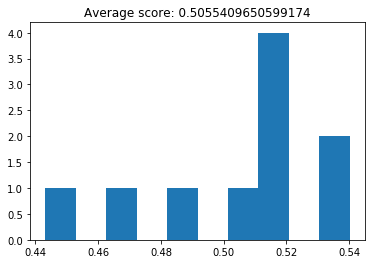

In [12]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, features, labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

In [13]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(features, labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.5062809288161401
Best parameters: {'max_depth': 4, 'max_features': 3}


''

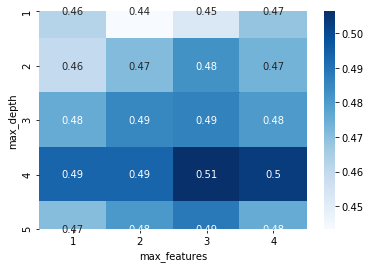

In [14]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (5, 4)
sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

In [15]:

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(features, labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.5024743052912067
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 3, 'splitter': 'best'}


In [16]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [17]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(features, labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.5059002664636467
Best parameters: {'criterion': 'gini', 'max_features': 1, 'n_estimators': 100}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

''

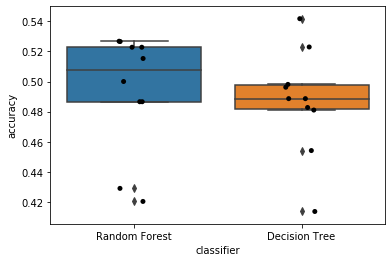

In [19]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, features, labels, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, features, labels, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sns.boxplot(x='classifier', y='accuracy', data=both_df)
sns.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;

<h3>KNN Algorithm</h3>
<p> K-nearest neighbors with an Euclidean distance measure is sensitive to magnitudes and hence should be scaled for all features to weigh in equally.</p>
<p>The following one is with using 20% of the entries for test and the rest to train</p>

In [22]:
from sklearn.preprocessing import StandardScaler

X1_train, X1_test, Y1_train, Y1_test = train_test_split(features, labels, test_size=0.20)

scaler = StandardScaler()
scaler.fit(X1_train)

X1_train = scaler.transform(X1_train)
X1_test = scaler.transform(X1_test)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X1_train, Y1_train)
y1_pred = classifier.predict(X1_test)

y1_pred = classifier.predict(X1_test)

print(confusion_matrix(Y1_test, y1_pred))
print(classification_report(Y1_test, y1_pred))

[[ 82  31  43]
 [ 49  38  41]
 [ 70  52 120]]
              precision    recall  f1-score   support

           0       0.41      0.53      0.46       156
           1       0.31      0.30      0.31       128
           2       0.59      0.50      0.54       242

    accuracy                           0.46       526
   macro avg       0.44      0.44      0.43       526
weighted avg       0.47      0.46      0.46       526



<h5>Using k-fold cross validation:</h5>

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

knn_cv = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_cv, features, labels, cv=5)
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))
knn2 = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
knn_gscv.fit(features, labels)
#knn_gscv.best_params_
knn_gscv.best_score_

[0.43155894 0.42585551 0.46666667 0.41333333 0.43809524]
cv_scores mean:0.4351019373528879


0.4800144848814051

<p>Now we should try to find the best parameters</p>

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)


params_KNN = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 
              'weights': ['uniform', 'distance'],
              'p': [1, 2, 5, 8 , 16]}

grid = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=params_KNN, 
                      cv=cv_method,
                      verbose=1,
                      scoring='accuracy', 
                      return_train_score=True)

grid.fit(features, labels)
grid.best_score_

Fitting 15 folds for each of 70 candidates, totalling 1050 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1050 out of 1050 | elapsed: 26.7min finished


0.45451071277687244

In [46]:
grid.cv_results_['mean_test_score']

array([0.41098871, 0.41200217, 0.39829682, 0.38980723, 0.39017828,
       0.36987796, 0.43306247, 0.43522071, 0.42380301, 0.43039628,
       0.43674163, 0.42443599, 0.43535059, 0.43547034, 0.42430998,
       0.44029742, 0.44067838, 0.43382365, 0.44664639, 0.44828849,
       0.44321589])

In [51]:
results_KNN = pd.DataFrame(grid.cv_results_['params'])
results_KNN['test_score'] = grid.cv_results_['mean_test_score']
results_KNN['metric'] = results_KNN['p'].replace([1,2,5], ["Manhattan", "Euclidean", "Minkowski"])
results_KNN

,n_neighbors,p,test_score,metric
0,1,1,0.410989,Manhattan
1,1,2,0.412002,Euclidean
2,1,5,0.398297,Minkowski
3,2,1,0.389807,Manhattan
4,2,2,0.390178,Euclidean
5,2,5,0.369878,Minkowski
6,3,1,0.433062,Manhattan
7,3,2,0.435221,Euclidean
8,3,5,0.423803,Minkowski
9,4,1,0.430396,Manhattan


<h3>We should test different K values</h3>

In [24]:
'''
error_rate = []
for i in range(1,40):

    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error_rate, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')'''


"\nerror_rate = []\nfor i in range(1,40):\n\n    knn = KNeighborsClassifier(n_neighbors=i)\n    knn.fit(X_train,Y_train)\n    pred_i = knn.predict(X_test)\n    error_rate.append(np.mean(pred_i != Y_test))\n    \nplt.figure(figsize=(12, 6))\nplt.plot(range(1, 40), error_rate, color='red', linestyle='dashed', marker='o',\n         markerfacecolor='blue', markersize=10)\nplt.title('Error Rate K Value')\nplt.xlabel('K Value')\nplt.ylabel('Mean Error')"

# Support Vector Machines

In [36]:
from sklearn import svm

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)


#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [42]:
#Testing
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, average='micro'))
print("Recall:",metrics.recall_score(y_test, y_pred, average='micro'))

Accuracy: 0.5019011406844106
Precision: 0.5019011406844106
Recall: 0.5019011406844106


# Neural Networks

### Building a Custom Model

In [26]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            8, activation="relu", input_shape=(features.shape[-1],)
        ),
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(3, activation="softmax"),
    ]
)
model.summary()

W0512 17:53:02.089933 16296 deprecation.py:506] From C:\Users\35192\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 256       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

### Model Training

In [27]:
fold = "1"

train_features = pd.read_csv(os.path.join('folds' + os.sep + 'train', fold + '.csv')).drop('Unnamed: 0', axis=1)
train_targets = to_categorical(pd.read_csv(os.path.join('targets' + os.sep + 'train', fold + '.csv')).drop('Unnamed: 0', axis=1))
val_features = pd.read_csv(os.path.join('folds' + os.sep + 'validate', fold + '.csv')).drop('Unnamed: 0', axis=1)
val_targets = to_categorical(pd.read_csv(os.path.join('targets' + os.sep + 'validate', fold + '.csv')).drop('Unnamed: 0', axis=1))

mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std

from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(
    lr=0.001
)

model.compile(
   loss='categorical_crossentropy', optimizer=opt, metrics=['acc']
)

mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std

print(train_features.shape)
print(train_targets.shape)

history = model.fit(
    train_features,
    train_targets,
    batch_size=1024,
    epochs=30,
    validation_data=(val_features, val_targets),
)

# Save weights
model.save_weights(os.path.join('weights' + os.sep + 'custom', fold + '.h5'))

(2101, 31)
(2101, 3)
Train on 2101 samples, validate on 526 samples
Epoch 1/30
2101/2101 [==============================] - 1s 296us/sample - loss: 1.1028 - acc: 0.3636 - val_loss: 1.0693 - val_acc: 0.4753
Epoch 2/30
2101/2101 [==============================] - 0s 29us/sample - loss: 1.0703 - acc: 0.4422 - val_loss: 1.0426 - val_acc: 0.4639
Epoch 3/30
2101/2101 [==============================] - 0s 24us/sample - loss: 1.0614 - acc: 0.4584 - val_loss: 1.0324 - val_acc: 0.4639
Epoch 4/30
2101/2101 [==============================] - 0s 25us/sample - loss: 1.0471 - acc: 0.4731 - val_loss: 1.0240 - val_acc: 0.4677
Epoch 5/30
2101/2101 [==============================] - 0s 24us/sample - loss: 1.0377 - acc: 0.4883 - val_loss: 1.0161 - val_acc: 0.4829
Epoch 6/30
2101/2101 [==============================] - 0s 24us/sample - loss: 1.0402 - acc: 0.4769 - val_loss: 1.0189 - val_acc: 0.4905
Epoch 7/30
2101/2101 [==============================] - 0s 23us/sample - loss: 1.0281 - acc: 0.4855 - val_los

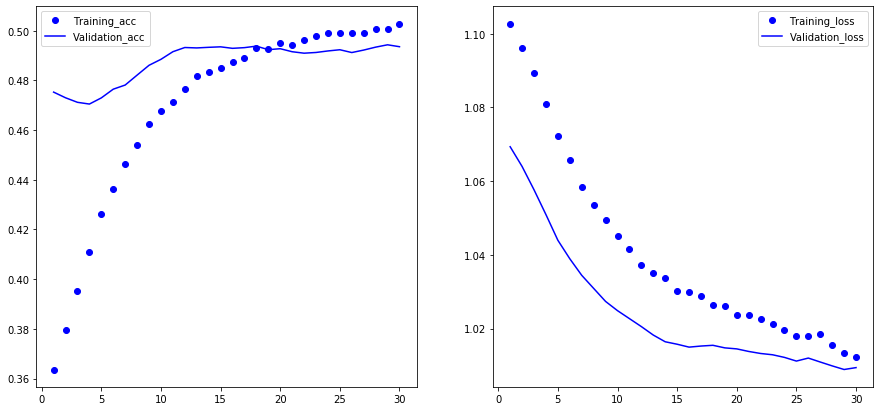

In [30]:
 # Plot history
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

acc = smooth_curve(history.history['acc'])
val_acc = smooth_curve(history.history['val_acc'])
loss = smooth_curve(history.history['loss'])
val_loss = smooth_curve(history.history['val_loss'])
epochs = range(1, len(acc) + 1)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].plot(epochs, acc, 'bo', label='Training_acc')
axs[0].plot(epochs, val_acc, 'b', label='Validation_acc')
axs[0].legend()
axs[1].plot(epochs, loss, 'bo', label='Training_loss')
axs[1].plot(epochs, val_loss, 'b', label='Validation_loss')
axs[1].legend()
plt.show()

### Testing

In [33]:
pred_train= model.predict(train_features)
scores = model.evaluate(train_features, train_targets, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}\n'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(val_features)
scores2 = model.evaluate(val_features, val_targets, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

Accuracy on training data: 0.5130890011787415% 
 Error on training data: 0.48691099882125854

Accuracy on test data: 0.4904943108558655% 
 Error on test data: 0.5095056891441345
